# ML-7. Оптимизация гиперпараметров модели

## 1. Введение

Цели модуля:
* Узнать, какие есть базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV);
* Узнать, какие есть продвинутые способами оптимизации (Hyperopt, Optuna);
* Научиться их настраивать и обучать модели с их использованием,  так, чтобы улучшать итоговую метрику.  
* Провести сравнение и понять преимущества и недостатки каждого из методов


## 2. Базовая оптимизация

In [6]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import model_selection
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

### Описание задачи

Продолжим решать задачу кассификации из модуля ML-3: "Предсказание категории дохода человека"

Данные, с которыми мы будем работать были извлечены из базы данных **Бюро переписи населения 1994 года** Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной - предсказание дохода.

Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50K $.


Данные, с которыми мы будем работать, были извлечены из базы данных Бюро переписи населения 1994 года Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной и заключалась в предсказании дохода. Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50 000 $.

Признаки:
* age — возраст
* workclass — сфера занятости
* fnlwgt — общий вес (число людей, которых, по мнению эксперта, представляет эта категория занятости)
* education — уровень образования
* education.num — образовательная ступень (в виде числа)
* marital.status — семейное положение
* occupation — род деятельности
* relationship — родственные отношения
* race — раса
* sex — пол
* capital.gain — ежегодный дополнительный прирост капитала
* capital.loss — ежегодная дополнительная потеря капитала
* hours.per.week — число рабочих часов в неделю
* native.country — страна рождения
* income — категория дохода (целевой признак — более 50К $ или менее 50К $)

### Знакомство с данными и их исследование

In [8]:
# ЕСЛИ РАБОТАЕМ В IDE
data = pd.read_csv('data/adult.zip')

# ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
# from google.colab import drive
# drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
# data = pd.read_csv('./drive/MyDrive/SF/SF module 7/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

Проверяем наличие пропусков

In [9]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [10]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Смотрим на сбалансированность классов:

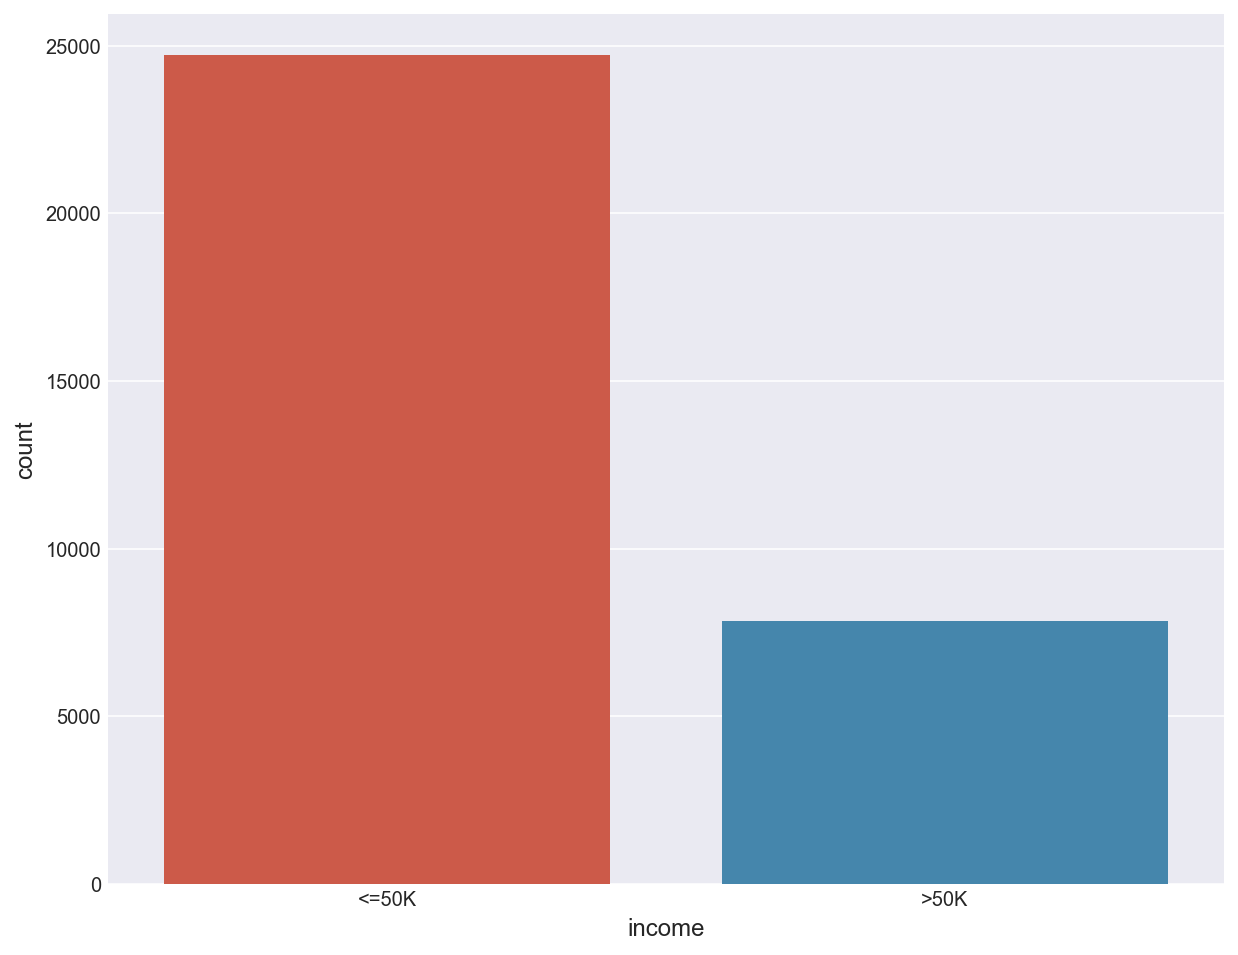

In [11]:
sns.countplot(data=data, x='income');

Для удобства переобозначим целевой признак (не обязательный шаг)

In [12]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [13]:
cat_features = data.select_dtypes('object').columns.to_list()
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

ValueError: Could not interpret input 'index'

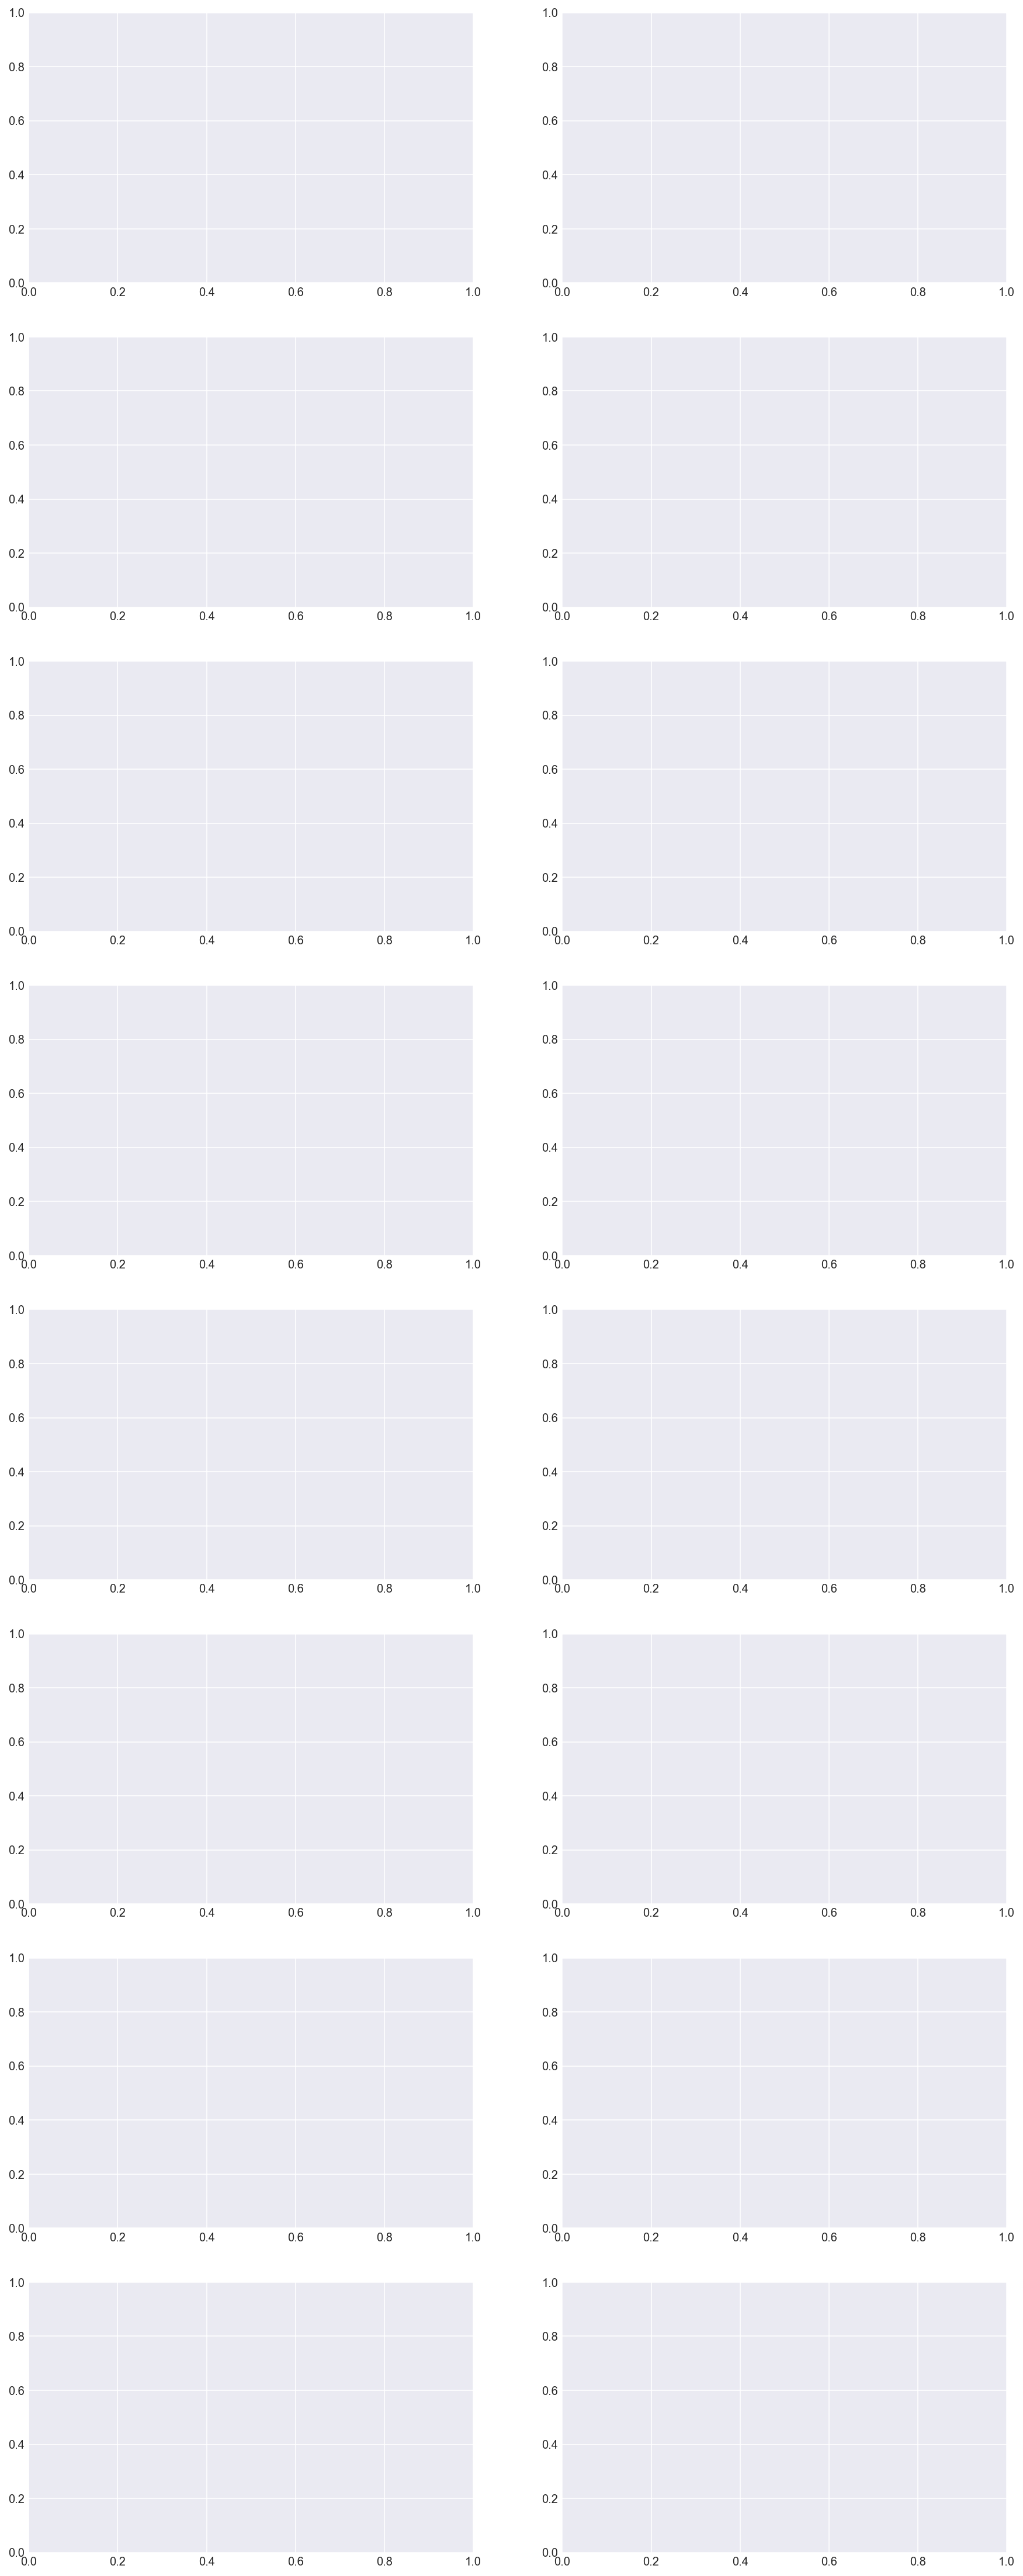

In [14]:
n = len(cat_features) # число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # фигура+n*2 координатных плоскостей

# Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    # Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    
    count_barplot = sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    
    # Строим столбчатую диаграмму доли людей зарабатывающих >50K 
    # (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1], order=count_data[feature].to_list())
    mean_barplot.xaxis.set_tick_params(rotation=60)
    
plt.tight_layout() # выравнивание графиков

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [15]:
adult_data = data.copy()

# Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)

# Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)

# Объединяем вдовцов, разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)

# Объединяем всех женатых/ за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)

# Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

# Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)

# Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [16]:
# Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain'] + 1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss'] + 1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt'] + 1)

# Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [17]:
# Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Проверяем результаты предобработки

In [18]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

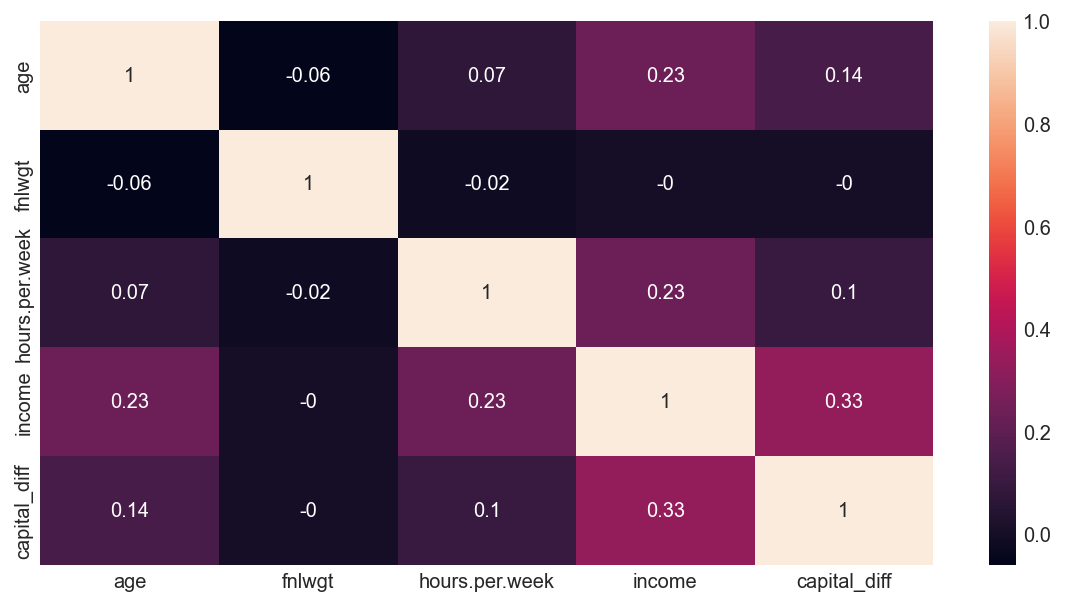

In [19]:
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.select_dtypes(exclude='object').corr().round(2), annot=True);

Кодируем текстовые категориальные признаки

In [20]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
1,82,11.797134,18,0,8.379539,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
2,66,12.133835,40,0,8.379539,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,True
3,54,11.851966,40,0,8.268988,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
4,41,12.486216,40,0,8.268988,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [21]:
X, y = dummies_data.drop(['income'], axis=1), dummies_data['income']

* Разделяем выборку на тренировочную и тестовую в соотношении 80/20. 
* Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [23]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [24]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.84
f1_score на train наборе: 0.64

accuracy_score на test наборе: 0.84
f1_score на test наборе: 0.64


## 3. Продвинутая оптимизация.

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации, поэтому в идеале мы хотим делать это самым эффективным образом. Один из способов  — это выбор следующей комбинации гиперпараметров на основе прошлых результатов. 
Байесовская оптимизация отличается от случайного поиска или поиска по сетке тем, что делает именно это: вместо того, чтобы просто выбирать комбинации из сетки, не имеющей информации о прошлых оценках, байесовские методы учитывают предыдущие результаты, чтобы попробовать более многообещающие комбинации значений. Это позволяет во многих случаях найти лучшие значения гиперпараметров модели за меньшее количество времени.
Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей машинного обучения.

### <center> Hyperopt

In [25]:
# Устанавливаем библиотеку
# !pip install hyperopt
# или
#!conda install -c conda-forge hyperopt

In [26]:
# делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print(f'Версия Hyperopt : {hyperopt.__version__}')

Версия Hyperopt : 0.2.7


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [48]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [30]:
# зафксируем random_state
random_state = 42

def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [50]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:12<00:00,  3.62s/trial, best loss: -0.7548124717577949]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 49.5 s
Wall time: 1min 12s


In [51]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')


accuracy_score на train наборе: 0.90
f1_score на train наборе: 0.75

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.67


Мы можем продолжить поиск гиперпараметров, чтобы получить лучшие результаты.

Для байесовских оптимизаторов это возможно, так как они ориентируются на прошлые результаты: предыдущие входные данные для целевой функции и результирующие потери.

Hyperopt продолжит поиск с того места, где он остановился, если мы передадим ему объект Trials, который уже содержит информацию о предыдущих запусках.

Всегда сохраняйте свои предыдущие результаты.

In [52]:
%%time
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=26, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )

print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 26/26 [00:20<00:00,  3.37s/trial, best loss: -0.7784334763948497]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 2.0, 'n_estimators': 101.0}
CPU times: total: 13.6 s
Wall time: 20.2 s


Видим, что Hyperot смог улучшить нашу метрику, причем за меньшее время.

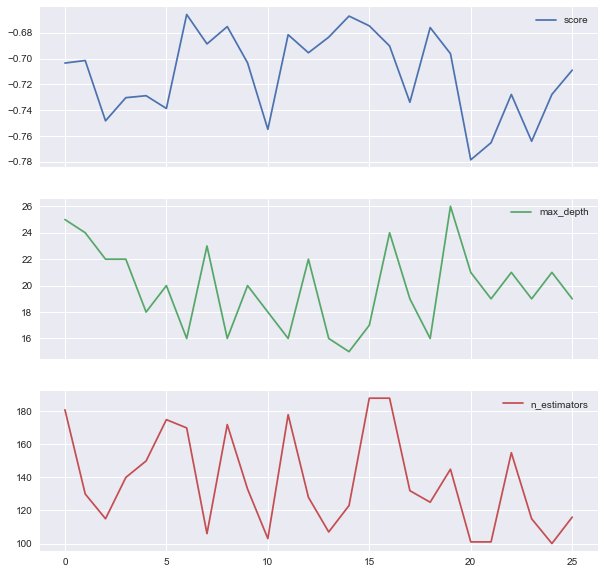

In [53]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results, columns=['score', 'max_depth', 'n_estimators'])

# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

По графикам видно, что лучшая точность достигается именно в best_params. Но заметьте, что метрика отрицательная, так как нам необходимо максимизировать нашу метрику, в то время как,  hyperopt может только минимизировать.

### Задание 3.5
Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:
* n_estimators = от 100 до 300 включительно с шагом 10
* min_samples_leaf = от 3 до 7 с шагом 1
* max_depth = от 15 до 40 с шагом 1

Используйте Hyperopt с параметрами n_iter = 20.

In [54]:
# зададим пространство поиска гиперпараметров
space={'n_estimators' : hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf' : hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [55]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:36<00:00,  4.83s/trial, best loss: -0.7639828998931244]
Наилучшие значения гиперпараметров {'max_depth': 30.0, 'min_samples_leaf': 3.0, 'n_estimators': 130.0}
CPU times: total: 1min 12s
Wall time: 1min 36s


In [56]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.90
f1_score на train наборе: 0.76

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.68


In [58]:
%%time

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=30, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 30/30 [01:04<00:00,  6.47s/trial, best loss: -0.7708463112930497]
Наилучшие значения гиперпараметров {'max_depth': 39.0, 'min_samples_leaf': 3.0, 'n_estimators': 220.0}
CPU times: total: 42.1 s
Wall time: 1min 4s


In [59]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.90
f1_score на train наборе: 0.77

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.68


In [34]:
# зададим пространство поиска гиперпараметров
space={'n_estimators' : hp.quniform('n_estimators', 100, 600, 10),
       'max_depth' : hp.quniform('max_depth', 10, 40, 1),
       'min_samples_leaf' : hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Вариант кросс-валидации со стратификацией

In [35]:
random_state = 42

def hyperopt_rf(params, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    # model.fit(X, y)
    # score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    skf = model_selection.StratifiedKFold(n_splits=5)
    score = cross_val_score(model, X, y, cv=skf, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [36]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [02:34<00:00,  7.74s/trial, best loss: -0.6632523961404557]
Наилучшие значения гиперпараметров {'max_depth': 23.0, 'min_samples_leaf': 3.0, 'n_estimators': 480.0}
CPU times: total: 328 ms
Wall time: 2min 34s


In [37]:
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=30, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 30/30 [01:49<00:00, 10.93s/trial, best loss: -0.6655148215045585]
Наилучшие значения гиперпараметров {'max_depth': 30.0, 'min_samples_leaf': 2.0, 'n_estimators': 360.0}


In [38]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.92
f1_score на train наборе: 0.82

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.68
